In [253]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['prices.csv', 'securities.csv', 'prices-split-adjusted.csv', 'fundamentals.csv']


# ARIMA model for NYSE stock data

### Import other modules

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

### Import data and check head

In [255]:
df = pd.read_csv('../input/prices-split-adjusted.csv', index_col=0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### Input from user to select company for ARIMA model

In [256]:
# Filter dataframe only for chosen ticker symbol
dfa = df[df['symbol'] == 'AAPL']

In [257]:
dfa.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [258]:
dfa.index.sort_values()

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
      dtype='object', name='date', length=1762)

In [259]:
# Convert index to pandas datetime
dfa.index = pd.to_datetime(dfa.index, format="%Y/%m/%d")

In [260]:
df_final = dfa.drop(['symbol','open','low','high','volume'], axis=1)

In [261]:
# Conver to Series to run Dickey-Fuller test
df_final = pd.Series(df_final['close'])

In [262]:
type(df_final)

pandas.core.series.Series

## Function to check stationarity

In [263]:
def check_stationarity(ts_data):
    
    # Rolling statistics
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(5).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))
    

Dickey-Fuller test results

Test Statistic      -1.324458
p-value              0.617910
# of lags            0.000000
# of obs          1761.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


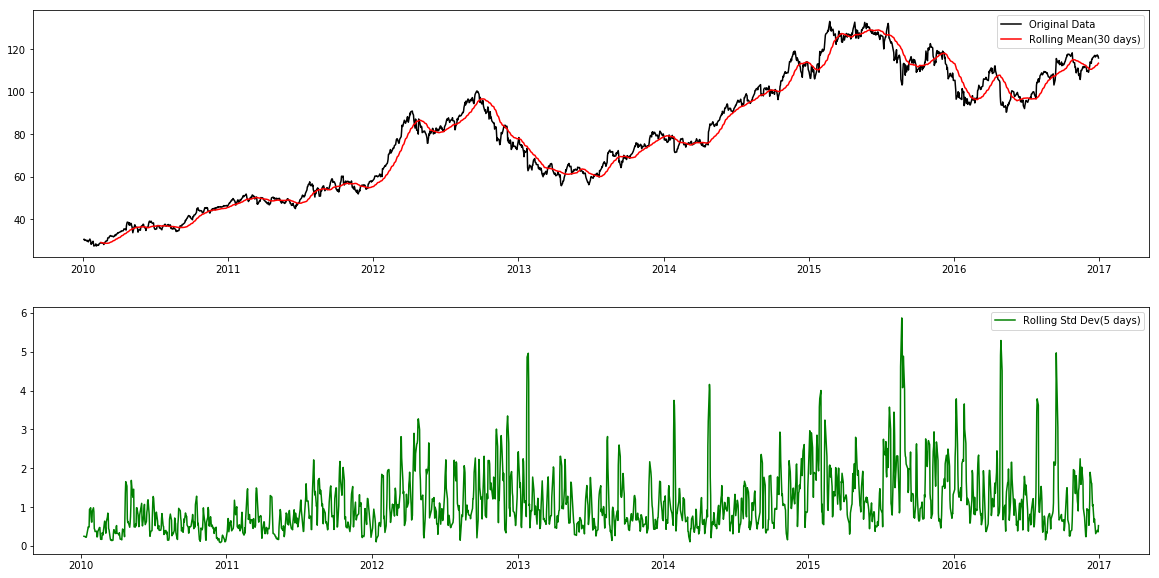

In [264]:
check_stationarity(df_final)

#### As Test statistic is greater than all critical values, the time series is clearly not stationary. Testing different transformations for stationarity is required before applying ARIMA model to time series.

### Log transformation of original time series

In [265]:
# Log transform time series
df_final_log = np.log(df_final)
df_final_log.head()

date
2010-01-04    3.420113
2010-01-05    3.421840
2010-01-06    3.405806
2010-01-07    3.403955
2010-01-08    3.410582
Name: close, dtype: float64

Dickey-Fuller test results

Test Statistic      -1.909807
p-value              0.327462
# of lags            0.000000
# of obs          1761.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


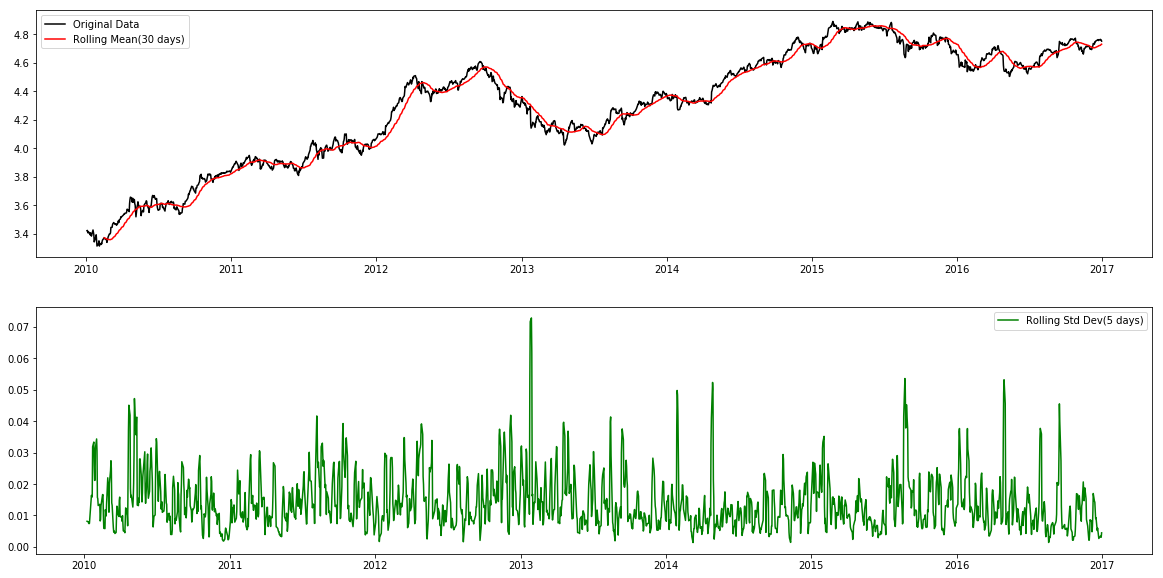

In [266]:
# Check stationarity
df_final_log.dropna(inplace=True)
check_stationarity(df_final_log)

### The log transformation is not stationary as test statistic is greater than critical values and you can also visualize this on the 1st graph.

### Log differencing transformation of original time series

In [267]:
# Log Differencing
df_final_log_diff = df_final_log - df_final_log.shift()

Dickey-Fuller test results

Test Statistic     -40.914822
p-value              0.000000
# of lags            0.000000
# of obs          1760.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


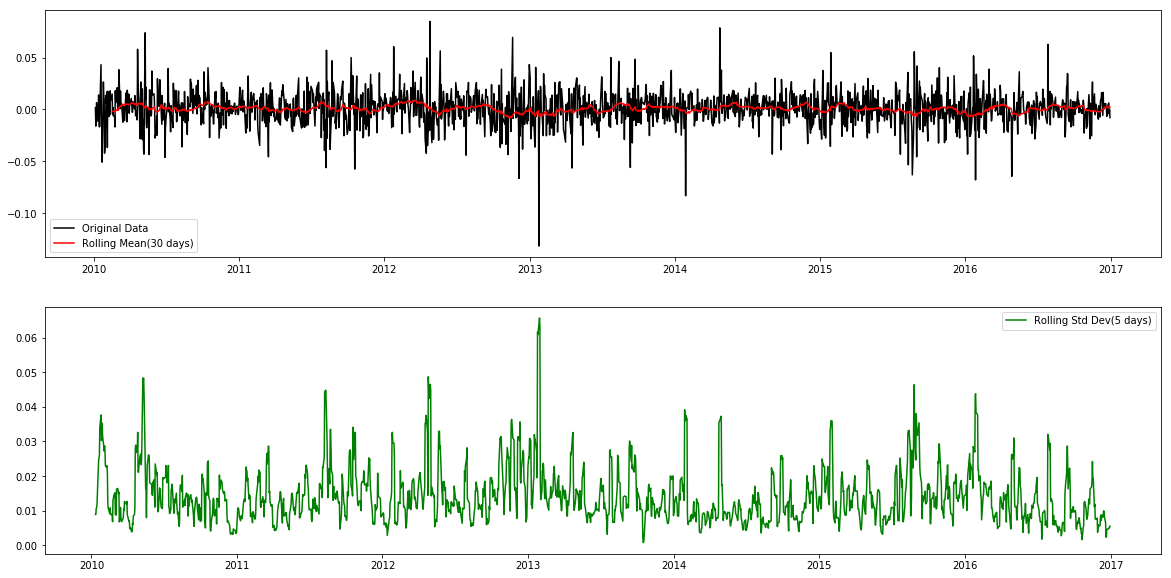

In [268]:
df_final_log_diff.dropna(inplace=True)
check_stationarity(df_final_log_diff)

### Simple differencing transformation of original time series

In [269]:
# Differencing
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic     -41.122158
p-value              0.000000
# of lags            0.000000
# of obs          1760.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


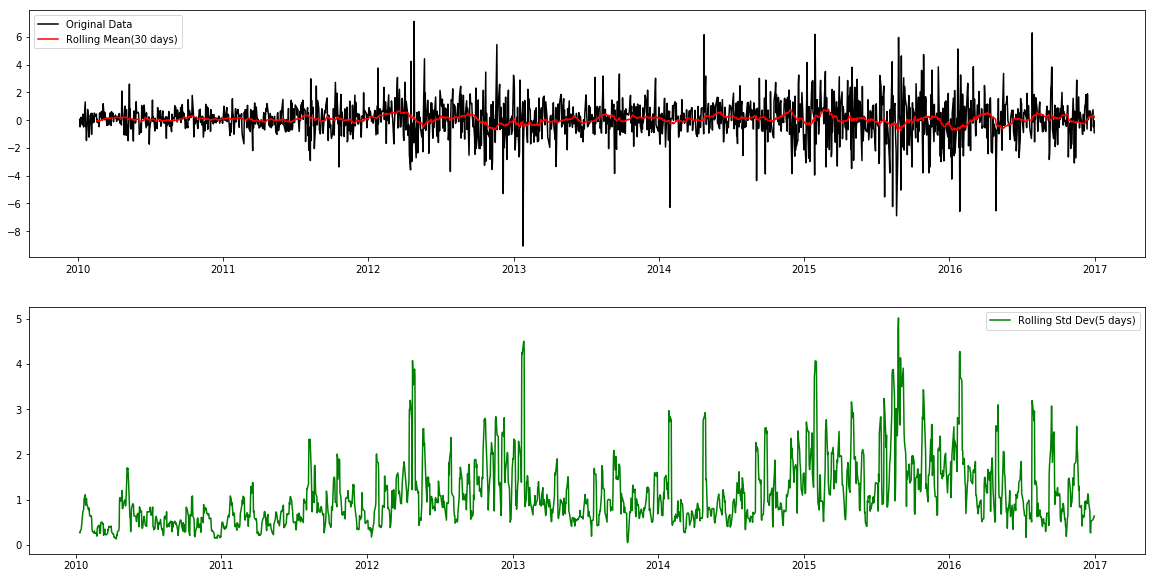

In [270]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

### As simple differencing yields a test statistic much lower than critical values, we will use this for applying ARIMA.

In [271]:
from statsmodels.tsa.stattools import acf, pacf

In [272]:
df_acf = acf(df_final_diff)

In [273]:
df_pacf = pacf(df_final_diff)

In [274]:
import statsmodels.api as sm

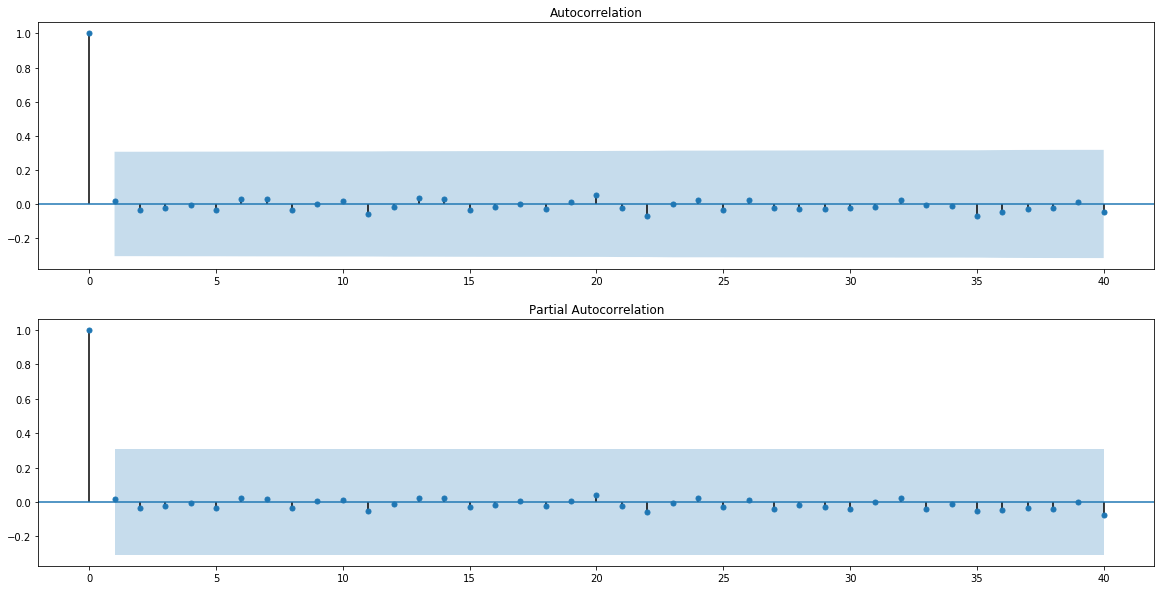

In [275]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_pacf, ax=ax2)

In [276]:
model = ARIMA(df_final_diff, (1,1,0))

In [277]:
fit_model = model.fit(full_output=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [278]:
predictions = model.predict(fit_model.params, start=1760, end=1769)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [279]:
fit_model.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1760
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3376.018
Method:                       css-mle   S.D. of innovations              1.647
Date:                Thu, 12 Jul 2018   AIC                           6758.035
Time:                        03:12:00   BIC                           6774.454
Sample:                    01-06-2010   HQIC                          6764.103
                         - 12-30-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.027     -0.011      0.991      -0.052       0.052
ar.L1.D.close    -0.4772      0.021    -22.794      0.000      -0.518      -0.436
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0954           +0.0000j            2.0954            0.5000
-----------------------------------------------------------------------------
"""

In [280]:
predictions

array([-0.22472244,  0.41954225, -0.20064195,  0.09532939, -0.04591741,
        0.02148999, -0.01067893,  0.00467309, -0.00265338,  0.00084304])

In [281]:
fit_model.predict(start=1760, end=1769)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


1760   -0.224722
1761    0.419542
1762   -0.200642
1763    0.095329
1764   -0.045917
1765    0.021490
1766   -0.010679
1767    0.004673
1768   -0.002653
1769    0.000843
dtype: float64

### Time to re-transform data back to original scale

In [282]:
pred_model_diff = pd.Series(fit_model.fittedvalues, copy=True)
pred_model_diff.head()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


date
2010-01-06   -0.000287
2010-01-07    0.257281
2010-01-08   -0.206315
2010-01-11   -0.122458
2010-01-12    0.222512
dtype: float64

In [283]:
# Calculate cummulative sum of the fitted values (cummulative sum of differences)
pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

date
2010-01-06   -0.000287
2010-01-07    0.256995
2010-01-08    0.050680
2010-01-11   -0.071778
2010-01-12    0.150734
dtype: float64

In [284]:
# Element-wise addition back to original time series
df_final_trans = df_final.add(pred_model_diff_cumsum, fill_value=0)
# Last 5 rows of fitted values
df_final_trans.tail()

date
2016-12-23    116.169622
2016-12-27    116.431976
2016-12-28    115.688160
2016-12-29    116.249507
2016-12-30    115.114782
dtype: float64

In [285]:
# Last 5 rows of original time series
df_final.tail()

date
2016-12-23    116.519997
2016-12-27    117.260002
2016-12-28    116.760002
2016-12-29    116.730003
2016-12-30    115.820000
Name: close, dtype: float64

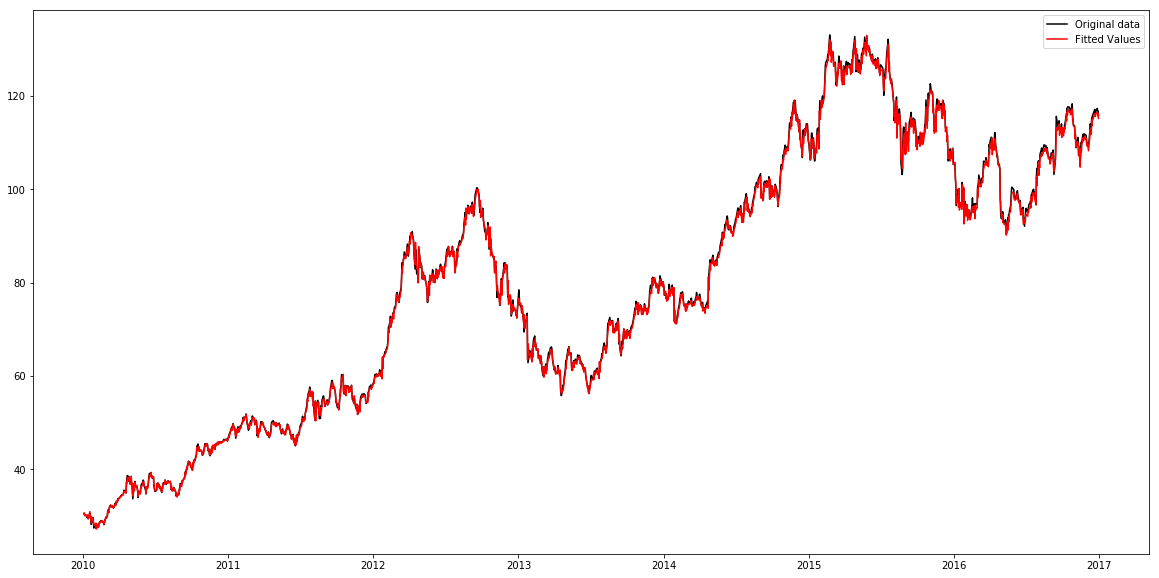

In [286]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20,10))
plt.plot(df_final, color='black', label='Original data')
plt.plot(df_final_trans, color='red', label='Fitted Values')
plt.legend()

In [287]:
x = df_final.values
y = df_final_trans.values

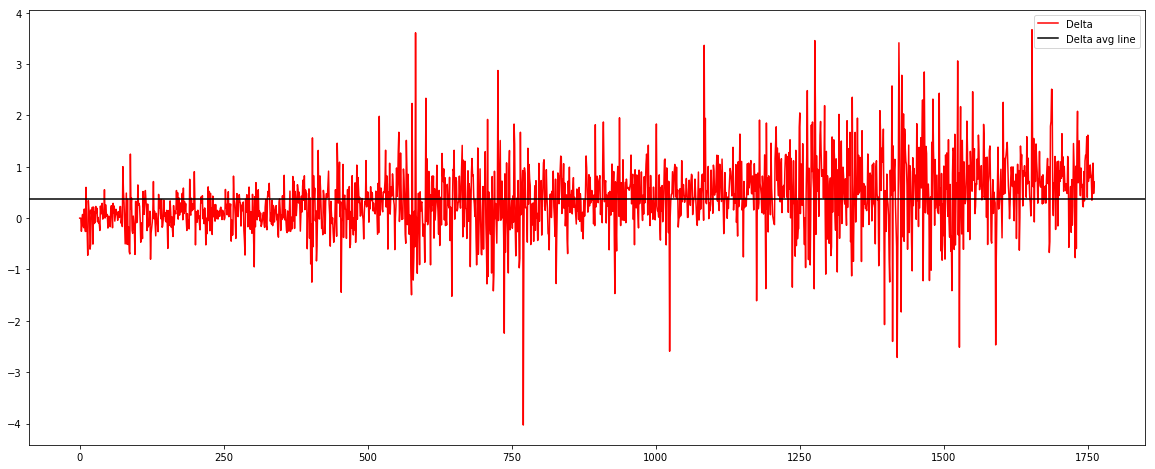

In [288]:
# Trend of error
plt.figure(figsize=(20,8))
plt.plot((x - y), color='red', label='Delta')
plt.axhline((x-y).mean(), color='black', label='Delta avg line')
plt.legend()

### Average error appears to be around $0.35 per share

## Final step is to create a Series with ten prediction values

In [289]:
final_pred = []
for i in predictions:
    t = df_final[-1] + i
    final_pred.append(t)

In [290]:
final_pred = pd.Series(final_pred)
final_pred

0    115.595278
1    116.239542
2    115.619358
3    115.915329
4    115.774083
5    115.841490
6    115.809321
7    115.824673
8    115.817347
9    115.820843
dtype: float64

### This is my first kernel. As the data ends by 2016, you can compare it to actual share of the comapny chosen by the user to stock data from Google or Yahoo finance. Comments are welcome!